In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Data Cleaning

Note: before this step, we've verified that the full dataset is balanced. Because the full dataset is too large to effectively work with, we randomly sampled 1% of the full dataset to perform EDA. We are also considering whether to use this sampled dataset for model training.

In [2]:
malware_df = pd.read_csv("../data/dev_small.csv")
malware_df

,Unnamed: 0,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,3778538,6c6f494003998c9383c76b2518152640,win8defender,1.1.15200.1,4.18.1807.18075,1.275.981.0,0,7.0,0,NaN,...,7221.0,0,0.0,0.0,0,0,0.0,0.0,10.0,1
1,6226655,b2b8432b649bd9f208d6a4c5cbf9e951,win8defender,1.1.15100.1,4.10.14393.1794,1.273.1652.0,0,7.0,0,NaN,...,59187.0,0,NaN,0.0,0,0,0.0,0.0,1.0,1
2,493959,0e336045e09ca390c67b54af6c0a35a9,win8defender,1.1.15200.1,4.18.1807.18075,1.275.644.0,0,7.0,0,NaN,...,20388.0,0,NaN,0.0,0,0,0.0,1.0,13.0,0
3,7450186,d5bec8d8f78c95afc0ed74c6b2ae83fa,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1552.0,0,7.0,0,NaN,...,42264.0,0,NaN,0.0,0,0,0.0,1.0,1.0,0
4,7625118,dac8c41a0d8d506561c110ff6c7256e2,win8defender,1.1.15200.1,4.18.1807.18075,1.275.948.0,0,7.0,0,NaN,...,26988.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89210,3261662,5d94137bc804b93923ce14981c4c9698,win8defender,1.1.15100.1,4.10.209.0,1.273.781.0,0,7.0,0,NaN,...,17556.0,1,NaN,0.0,1,0,0.0,0.0,11.0,1
89211,8545024,f5310851036f116efd7a2ab61b5625d4,win8defender,1.1.15200.1,4.13.17134.228,1.275.821.0,0,0.0,1,NaN,...,7936.0,0,NaN,0.0,0,1,0.0,0.0,7.0,1
89212,4234385,798290f94237de1d23603fc40e2bdc02,win8defender,1.1.15100.1,4.18.1807.18075,1.273.591.0,0,7.0,0,NaN,...,26312.0,1,NaN,0.0,0,0,0.0,0.0,3.0,0
89213,1870674,35b017e7cd9c839fbb2ea57d525e6fd0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1686.0,0,7.0,0,NaN,...,33145.0,1,NaN,0.0,1,1,0.0,0.0,13.0,0


In [3]:
print("# of machines w/ malware: " + str(malware_df['HasDetections'].sum()))
print("# of machines w/o malware: " + str(len(malware_df['HasDetections']) - malware_df['HasDetections'].sum()))

# of machines w/ malware: 44674
# of machines w/o malware: 44541


In [4]:
print(malware_df.dropna().shape)
print(malware_df.shape)
with pd.option_context('display.max_rows', None):
    display(malware_df.isna().sum())

(0, 84)
(89215, 84)


Unnamed: 0                                               0
MachineIdentifier                                        0
ProductName                                              0
EngineVersion                                            0
AppVersion                                               0
AvSigVersion                                             0
IsBeta                                                   0
RtpStateBitfield                                       330
IsSxsPassiveMode                                         0
DefaultBrowsersIdentifier                            84951
AVProductStatesIdentifier                              379
AVProductsInstalled                                    379
AVProductsEnabled                                      379
HasTpm                                                   0
CountryIdentifier                                        0
CityIdentifier                                        3262
OrganizationIdentifier                               276

Every row has at least one nan, so we can't just drop rows with missing values. However, there are certain columns
that have a lot more missing values than others, so we can just drop those columns. It doesn't make sense to try to
impute values for those columns as so many values are missing.

In [5]:
nan_counts = malware_df.isna().sum()

# We consider dropping columns that has more than 1000 nan values. This cutoff value is
# empirically chosen based on the above statistics

features_to_drop = nan_counts[nan_counts >= 1000].index.tolist()
print(features_to_drop)
print("Number of features to be dropped: ", len(features_to_drop))

['DefaultBrowsersIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'PuaMode', 'SMode', 'SmartScreen', 'Census_ProcessorClass', 'Census_InternalBatteryType', 'Census_InternalBatteryNumberOfCharges', 'Census_IsFlightingInternal', 'Census_IsFlightsDisabled', 'Census_ThresholdOptIn', 'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier', 'Census_IsWIMBootEnabled', 'Wdft_IsGamer', 'Wdft_RegionIdentifier']
Number of features to be dropped:  17


In [6]:
malware_df = malware_df.drop(columns=features_to_drop)
malware_df

,Unnamed: 0,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,...,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,HasDetections
0,3778538,6c6f494003998c9383c76b2518152640,win8defender,1.1.15200.1,4.18.1807.18075,1.275.981.0,0,7.0,0,53447.0,...,0,IS_GENUINE,Retail,Retail,0,0.0,0,0,0.0,1
1,6226655,b2b8432b649bd9f208d6a4c5cbf9e951,win8defender,1.1.15100.1,4.10.14393.1794,1.273.1652.0,0,7.0,0,NaN,...,0,IS_GENUINE,Retail,Retail,0,0.0,0,0,0.0,1
2,493959,0e336045e09ca390c67b54af6c0a35a9,win8defender,1.1.15200.1,4.18.1807.18075,1.275.644.0,0,7.0,0,53447.0,...,0,IS_GENUINE,OEM:NONSLP,Retail,0,0.0,0,0,0.0,0
3,7450186,d5bec8d8f78c95afc0ed74c6b2ae83fa,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1552.0,0,7.0,0,53447.0,...,0,INVALID_LICENSE,Retail,Retail,0,0.0,0,0,0.0,0
4,7625118,dac8c41a0d8d506561c110ff6c7256e2,win8defender,1.1.15200.1,4.18.1807.18075,1.275.948.0,0,7.0,0,53447.0,...,0,IS_GENUINE,Retail,Retail,0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89210,3261662,5d94137bc804b93923ce14981c4c9698,win8defender,1.1.15100.1,4.10.209.0,1.273.781.0,0,7.0,0,49545.0,...,0,IS_GENUINE,Retail,Retail,1,0.0,1,0,0.0,1
89211,8545024,f5310851036f116efd7a2ab61b5625d4,win8defender,1.1.15200.1,4.13.17134.228,1.275.821.0,0,0.0,1,57073.0,...,0,IS_GENUINE,OEM:DM,Retail,0,0.0,0,1,0.0,1
89212,4234385,798290f94237de1d23603fc40e2bdc02,win8defender,1.1.15100.1,4.18.1807.18075,1.273.591.0,0,7.0,0,53447.0,...,0,IS_GENUINE,Retail,Retail,1,0.0,0,0,0.0,0
89213,1870674,35b017e7cd9c839fbb2ea57d525e6fd0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1686.0,0,7.0,0,53447.0,...,0,IS_GENUINE,OEM:DM,Retail,1,0.0,1,1,0.0,0


In [7]:
print("Number of rows that have null values: ", malware_df.shape[0] - malware_df.dropna().shape[0])

Number of rows that have null values:  5201


We decide to then drop all rows that have null values, as their total number is insignificant in relation to the total size of the dataset[link text](https://).

In [8]:
malware_df = malware_df.dropna()
malware_df

,Unnamed: 0,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,...,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,HasDetections
0,3778538,6c6f494003998c9383c76b2518152640,win8defender,1.1.15200.1,4.18.1807.18075,1.275.981.0,0,7.0,0,53447.0,...,0,IS_GENUINE,Retail,Retail,0,0.0,0,0,0.0,1
2,493959,0e336045e09ca390c67b54af6c0a35a9,win8defender,1.1.15200.1,4.18.1807.18075,1.275.644.0,0,7.0,0,53447.0,...,0,IS_GENUINE,OEM:NONSLP,Retail,0,0.0,0,0,0.0,0
3,7450186,d5bec8d8f78c95afc0ed74c6b2ae83fa,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1552.0,0,7.0,0,53447.0,...,0,INVALID_LICENSE,Retail,Retail,0,0.0,0,0,0.0,0
4,7625118,dac8c41a0d8d506561c110ff6c7256e2,win8defender,1.1.15200.1,4.18.1807.18075,1.275.948.0,0,7.0,0,53447.0,...,0,IS_GENUINE,Retail,Retail,0,0.0,0,0,0.0,0
5,7218352,cf1abe3dcfa1fb6612215df83c3ae5d7,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1504.0,0,7.0,0,53447.0,...,0,IS_GENUINE,OEM:DM,Retail,1,0.0,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89210,3261662,5d94137bc804b93923ce14981c4c9698,win8defender,1.1.15100.1,4.10.209.0,1.273.781.0,0,7.0,0,49545.0,...,0,IS_GENUINE,Retail,Retail,1,0.0,1,0,0.0,1
89211,8545024,f5310851036f116efd7a2ab61b5625d4,win8defender,1.1.15200.1,4.13.17134.228,1.275.821.0,0,0.0,1,57073.0,...,0,IS_GENUINE,OEM:DM,Retail,0,0.0,0,1,0.0,1
89212,4234385,798290f94237de1d23603fc40e2bdc02,win8defender,1.1.15100.1,4.18.1807.18075,1.273.591.0,0,7.0,0,53447.0,...,0,IS_GENUINE,Retail,Retail,1,0.0,0,0,0.0,0
89213,1870674,35b017e7cd9c839fbb2ea57d525e6fd0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1686.0,0,7.0,0,53447.0,...,0,IS_GENUINE,OEM:DM,Retail,1,0.0,1,1,0.0,0


In [9]:
malware_df.drop("Unnamed: 0", axis=1, inplace=True)

# Preliminary Investigation on the remaining features

In [10]:
print(malware_df.columns)

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
       'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled',
       'HasTpm', 'CountryIdentifier', 'GeoNameIdentifier',
       'LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsVer',
       'OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab',
       'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'IeVerIdentifier',
       'Firewall', 'UacLuaenable', 'Census_MDC2FormFactor',
       'Census_DeviceFamily', 'Census_OEMNameIdentifier',
       'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount',
       'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity',
       'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity',
       'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM',
       'Census_ChassisTypeName',
       'Census_Interna

By analyzing the above features, we separated them into the following 4 categories:

**Identifiers**: AVProductStatesIdentifier, CountryIdentifier, GeoNameIdentifier, Census_OEMNameIdentifier, Census_ProcessorModelIdentifier, Census_ProcessorManufacturerIdentifier, Census_ProcessorModelIdentifier, Census_OSInstallLanguageIdentifier

**Categorical Variables**: ProductName, EngineVersion, AppVersion, AvSigVersion, IsBeta, RtpStateBitfield, IsSxsPassiveMode, HasTpm, Platform, Processor, OsVer, OsBuild, OsSuite, OsPlatformSubRelease, OsBuildLab, SkuEdition, IsProtected, IeVerIdentifier, Firewall, UacLuaenable, Census_MDC2FormFactor, Census_PrimaryDiskTypeName, Census_HasOpticalDiskDrive, Census_ChassisTypeName, Census_PowerPlatformRoleName, Census_OSVersion, Census_OSArchitecture, Census_OSBranch, Census_OSBuildNumber, Census_OSBuildRevision, Census_OSEdition, Census_OSSkuName, Census_OSInstallTypeName, Census_OSWUAutoUpdateOptionsName, Census_IsPortableOperatingSystem, Census_GenuineStateName, Census_ActivationChannel, Census_FlightRing, Census_IsSecureBootEnabled, Census_IsVirtualDevice, Census_IsTouchEnabled, Census_IsPenCapable, Census_IsAlwaysOnAlwaysConnectedCapable

**Numerical Variables**: AVProductsInstalled, AVProductsEnabled, Census_ProcessorCoreCount, Census_PrimaryDiskTotalCapacity, Census_SystemVolumeTotalCapacity, Census_TotalPhysicalRAM,

**Target Variable**: HasDetections

**To remove**: MachineIdentifier, LocaleEnglishNameIdentifier, AutoSampleOptIn, Census_DeviceFamily, Census_InternalPrimaryDiagonalDisplaySizeInInches, Census_InternalPrimaryDisplayResolutionHorizontal, Census_InternalPrimaryDisplayResolutionVertical, Census_OSUILocaleIdentifier

**Highly Important**: AVProductsInstalled, AVProductsEnabled, IsProtected, Firewall, UacLuaenable, Census_OSVersion, Census_OSArchitecture, Census_IsSecureBootEnabled, Census_IsVirtualDevice, Census_IsAlwaysOnAlwaysConnectedCapable

Most of the features in this dataset are **categorical**. This may imply that tree-based models are more suitable to be used in the project.

The **Highly Important** features are selected based on the background information on the features. These features can all potentially directly impact the possibility of a machine being infected by malewares. Therefore, we would like to focus our analysis on these attributes.

In [11]:
# Remove all unnecessary features

to_remove = ["MachineIdentifier", "LocaleEnglishNameIdentifier", "AutoSampleOptIn", "Census_DeviceFamily", "Census_InternalPrimaryDiagonalDisplaySizeInInches", "Census_InternalPrimaryDisplayResolutionHorizontal", "Census_InternalPrimaryDisplayResolutionVertical", "Census_OSUILocaleIdentifier"]

malware_df.drop(columns=to_remove, inplace=True)
malware_df

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,...,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,HasDetections
0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.981.0,0,7.0,0,53447.0,1.0,1.0,...,0,IS_GENUINE,Retail,Retail,0,0.0,0,0,0.0,1
2,win8defender,1.1.15200.1,4.18.1807.18075,1.275.644.0,0,7.0,0,53447.0,1.0,1.0,...,0,IS_GENUINE,OEM:NONSLP,Retail,0,0.0,0,0,0.0,0
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1552.0,0,7.0,0,53447.0,1.0,1.0,...,0,INVALID_LICENSE,Retail,Retail,0,0.0,0,0,0.0,0
4,win8defender,1.1.15200.1,4.18.1807.18075,1.275.948.0,0,7.0,0,53447.0,1.0,1.0,...,0,IS_GENUINE,Retail,Retail,0,0.0,0,0,0.0,0
5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1504.0,0,7.0,0,53447.0,1.0,1.0,...,0,IS_GENUINE,OEM:DM,Retail,1,0.0,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89210,win8defender,1.1.15100.1,4.10.209.0,1.273.781.0,0,7.0,0,49545.0,2.0,2.0,...,0,IS_GENUINE,Retail,Retail,1,0.0,1,0,0.0,1
89211,win8defender,1.1.15200.1,4.13.17134.228,1.275.821.0,0,0.0,1,57073.0,2.0,1.0,...,0,IS_GENUINE,OEM:DM,Retail,0,0.0,0,1,0.0,1
89212,win8defender,1.1.15100.1,4.18.1807.18075,1.273.591.0,0,7.0,0,53447.0,1.0,1.0,...,0,IS_GENUINE,Retail,Retail,1,0.0,0,0,0.0,0
89213,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1686.0,0,7.0,0,53447.0,1.0,1.0,...,0,IS_GENUINE,OEM:DM,Retail,1,0.0,1,1,0.0,0


# Data Visualization

Things to explore:

1. The distribution of each of the remaining features, either categorical or numerical

2. Does the highly important features have any correlation with the target variable?

3. Are there any highly correlated features?

4. Some of the features are highly connected. For example: The Census_OSBuildNumber and Census_OSBuildRevision. Consider grouping such features and analyzing their impact on the target variables as a whole.

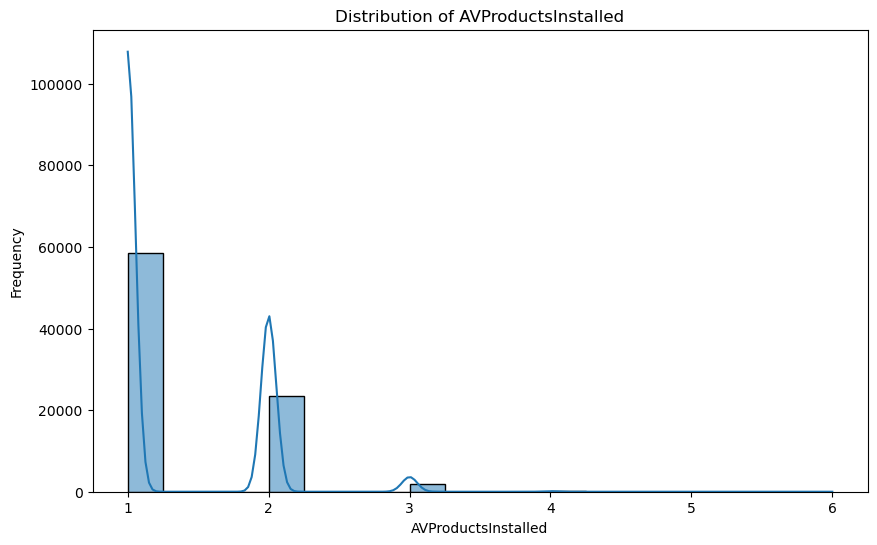

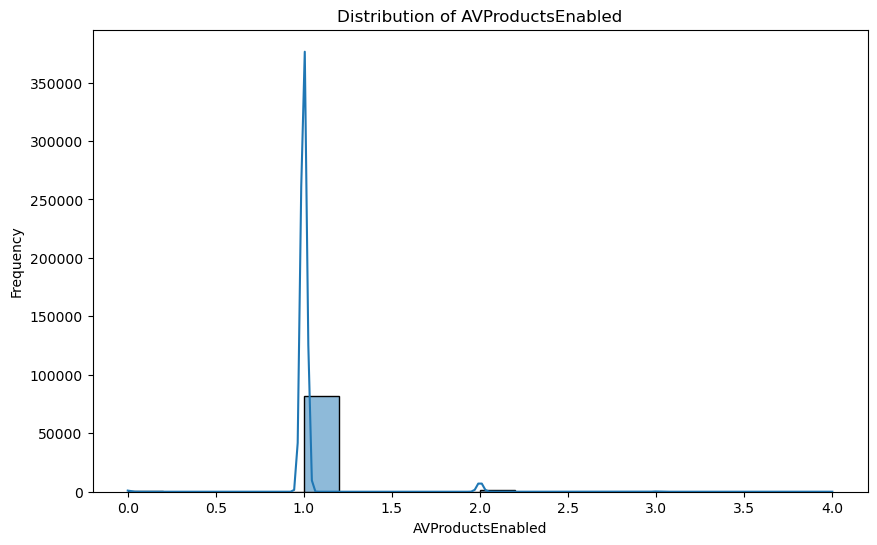

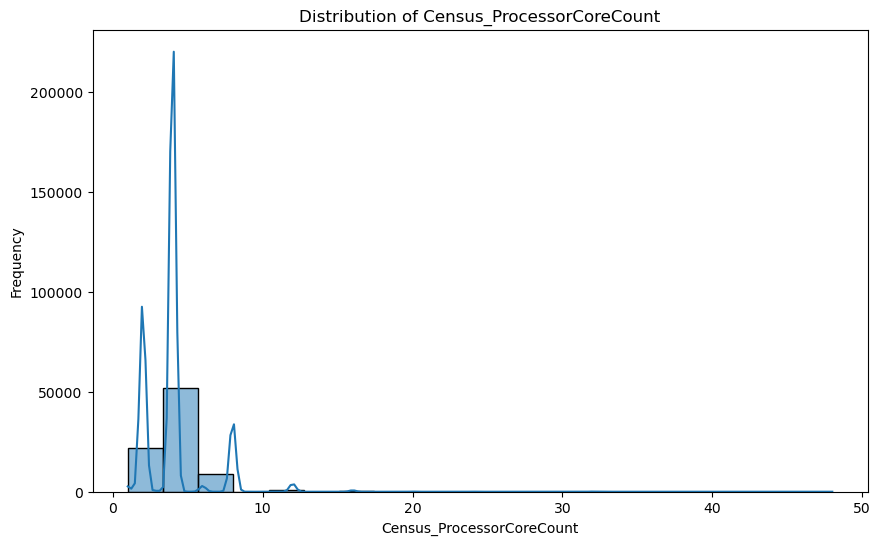

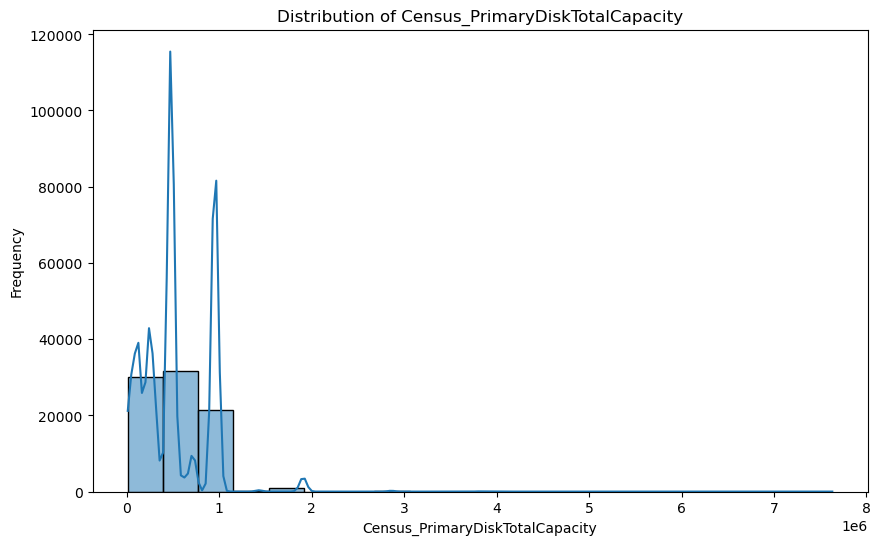

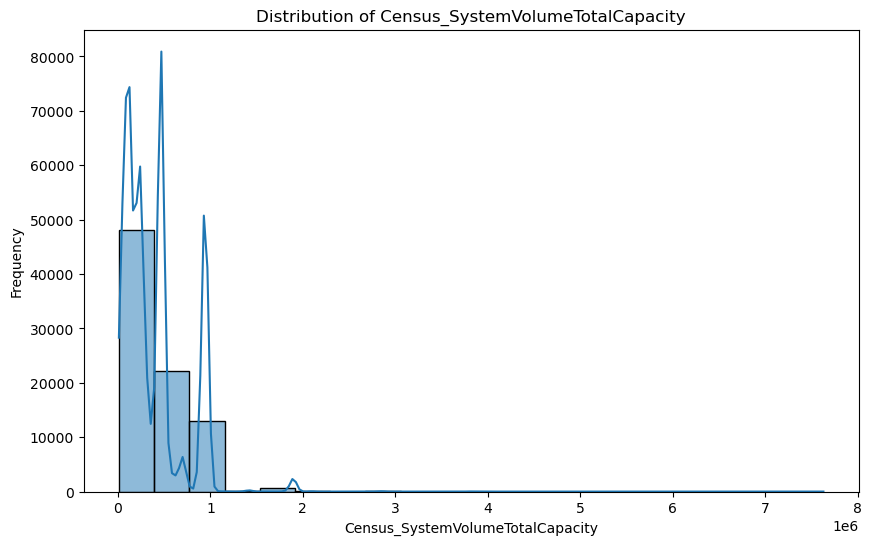

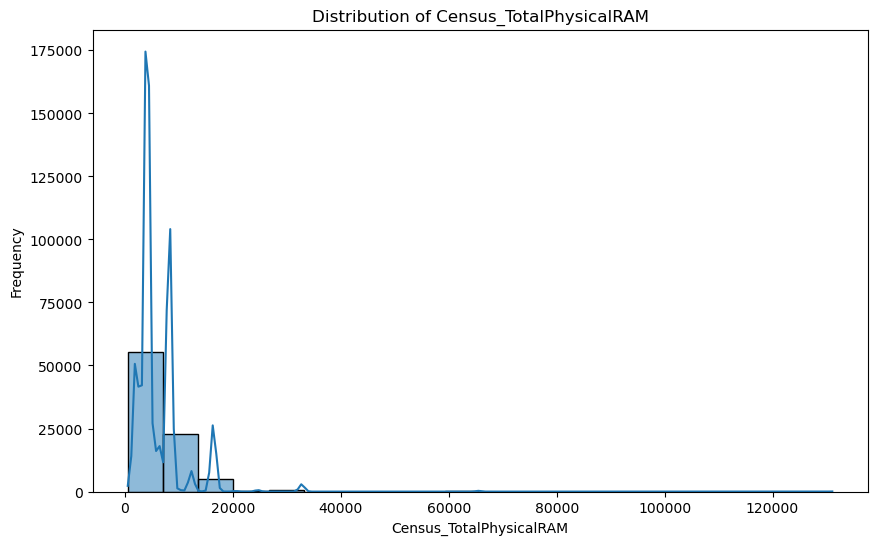

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical Features
numerical_features = ['AVProductsInstalled', 'AVProductsEnabled', 'Census_ProcessorCoreCount',
                      'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM']

# Plot histograms for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(malware_df[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


Distribution analysis of **AVProductsInstalled** histogram:

**Mode**: The highest peak, and thus the most common value, appears to be 1 antivirus product installed. This suggests that the
majority of the systems in the dataset have one antivirus product installed.

**Skewness**: The distribution is right-skewed, meaning that there are fewer systems with a larger number of antivirus products installed, but there's a long tail indicating that such systems do exist.

**Outliers**: Systems with more than 3 antivirus products installed appear to be quite rare when compared to the rest of the data, which might be considered outliers.

**Unimodal Distribution**: The distribution appears to be unimodal with a single predominant peak at 1 antivirus product installed. The distribution has a quick drop-off after 1 and a smaller peak at 2, suggesting a significant drop in frequency as the number of antivirus products increases.

Distribution analysis of **AVProductsEnabled** histogram:

**Mode**: The tallest bar is at 1, indicating that most systems have a single enabled antivirus product.

**Skewness**: The distribution is right-skewed, with a steep decline after 1 AVProductsEnabled. The skewness indicates that while the vast majority of systems only have one antivirus product enabled, there are still a number of systems with more than one.

**Outliers**: The data points representing more than 1 AVProductsEnabled are relatively few compared to the peak at 1 and could be considered as outliers.

Distribution analysis of **Census_ProcessorCoreCount** histogram:

**Mode**: The most common value, shown by the highest peak in the histogram, seems to be around 4 processor cores. This suggests that the majority of the computers in the census have quad-core processors.

**Skewness**: The distribution is right-skewed, as there is a long tail extending towards the higher number of processor cores. This indicates that there are fewer computers with a very high number of cores, but these values pull the mean to the right.

**Outliers**: The histogram has several bars on the right side that are separate from the main group of data, which could be considered outliers. These represent computers with a much higher number of processor cores than the average.

**Multi-Modality**: The histogram shows multiple peaks, or modes, which suggest that the data might have several popular processor core counts, such as 2, 4, and 8, which are typical configurations in consumer-grade computers.

Distribution analysis of **Census_PrimaryDiskTotalCapacity** histogram:

**Mode**: The most common storage capacities form distinct peaks, suggesting that common disk sizes are likely to be around 250GB, 500GB, and 1TB, which correspond to typical hard drive sizes available on the market.

**Skewness**: The distribution is right-skewed, with a tail stretching towards higher capacities. However, high-capacity drives are less frequent, as shown by the lower height of bars further to the right.

**Outliers**: Any bars significantly to the right of the 1TB mark might be considered outliers within the context of typical consumer hard drive sizes. These could represent enterprise storage systems or data errors.

Distribution analysis of **Census_SystemVolumeTotalCapacity** histogram:

**Mode**: There are several prominent peaks, suggesting that the most common system volume capacities are concentrated around specific sizes. These peaks might correspond to common disk sizes, although the exact values are not labeled.

**Skewness**: The distribution shows a right skew, as indicated by the tail extending towards higher capacities. The bulk of the data is concentrated on the lower end, indicating that systems with larger system volume capacities are less common.

**Outliers**: Given that the bars become sparse and infrequent beyond a certain point on the x-axis, it suggests the presence of outliers in the dataset, corresponding to systems with unusually high system volume capacities.

Distribution analysis of **Census_TotalPhysicalRAM** histogram:

**Mode**: The histogram has a strong peak around what appears to be the 4,000 to 8,000 MB range (4 to 8 GB), which is a common RAM size for many modern computers. This suggests that the majority of the systems have either 4GB or 8GB of RAM.

**Skewness**: The distribution is right-skewed, as indicated by a long tail extending towards higher RAM values. This suggests that while the most common amounts of RAM are lower (likely around 4 to 8 GB), there are a significant number of systems with more RAM, although they are less frequent.

**Outliers**: Systems with very high amounts of RAM, especially those approaching 120,000 MB, are much less frequent and can be considered outliers. These might represent high-performance workstations or servers.

In [13]:
highly_important_features = [
    "AVProductsInstalled", "AVProductsEnabled", "IsProtected", 
    "Firewall", "UacLuaenable", "Census_OSVersion", "Census_OSArchitecture", "Census_IsSecureBootEnabled",
    "Census_IsVirtualDevice", "Census_IsAlwaysOnAlwaysConnectedCapable", "HasDetections"
]

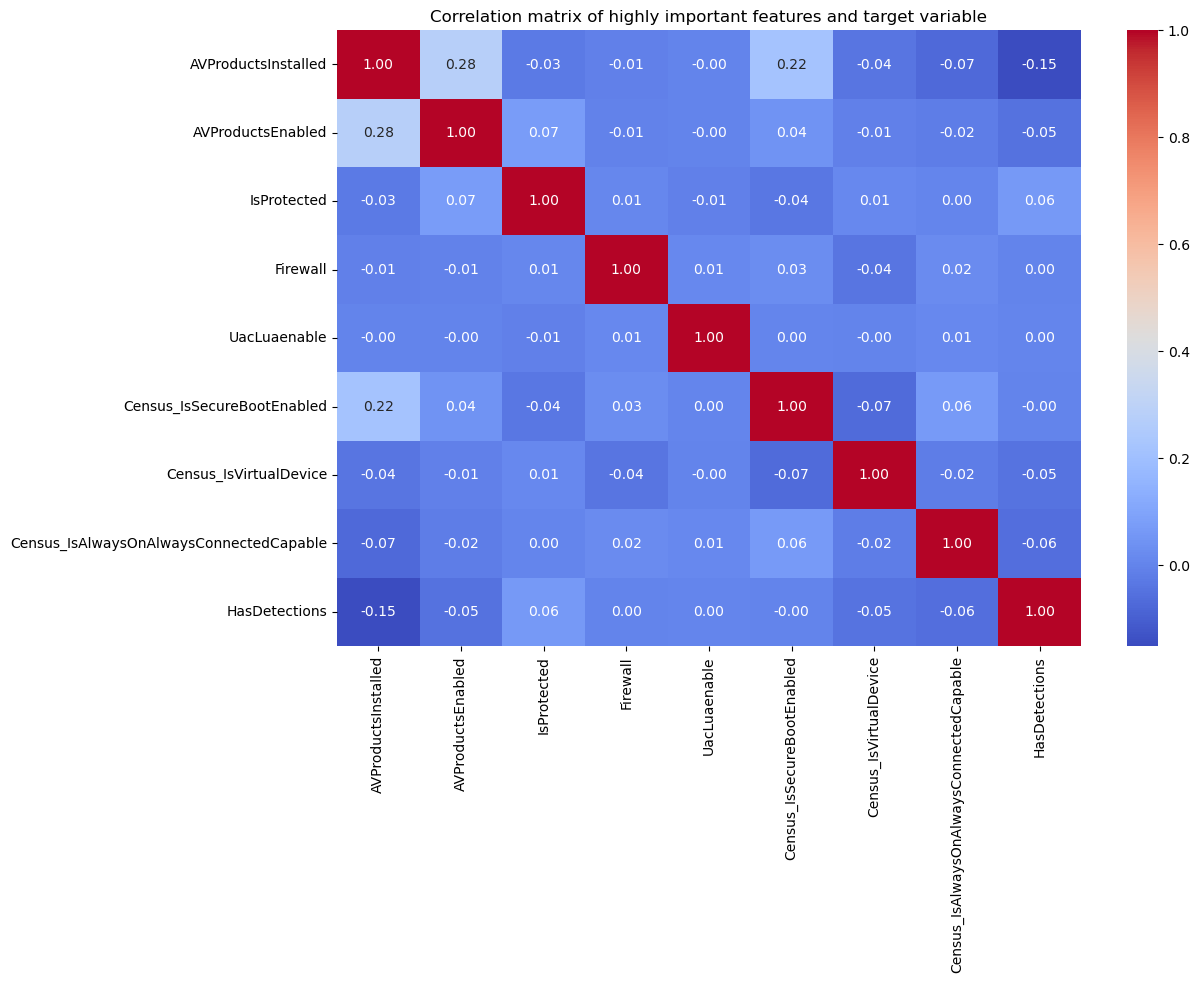

In [14]:
highly_important_features_numerical = [
    "AVProductsInstalled", "AVProductsEnabled", "IsProtected",
    "Firewall", "UacLuaenable", "Census_IsSecureBootEnabled",
    "Census_IsVirtualDevice", "Census_IsAlwaysOnAlwaysConnectedCapable", "HasDetections"
]
correlation_df = malware_df[highly_important_features_numerical]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Draw the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Correlation matrix of highly important features and target variable")
plt.show()

The correlation matrix does not include "Census_OSVersion" and "Census_OSArchitecture" because these features are categorical and not numerical.

In [15]:
# Try to perform Chi-Squared Test between Census_OSVersion" and"Census_OSArchitecture"

from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

# encode these categorical variables as numeric labels
# because chi-squared test requires numerical values
label_encoder = LabelEncoder()
os_version_encoded = label_encoder.fit_transform(malware_df['Census_OSVersion'])
os_architecture_encoded = label_encoder.fit_transform(malware_df['Census_OSArchitecture'])

# Since the OS Version has too many categories, performing a chi-squared test directly
# may not be very meaningful or could result in a very large contingency table.
# Therefore, we will limit our analysis to 'Census_OSArchitecture'.
chi2_val_architecture, p_val_architecture, _, _ = chi2_contingency(
    pd.crosstab(malware_df['HasDetections'], malware_df['Census_OSArchitecture'])
)

chi2_val_architecture, p_val_architecture



(475.36497722336696, 5.9676968141789e-104)

A chi-square test of the Census_OSArchitecture variable and the target variable HasDetections yields a chi-square statistic of 477.94, with a p-value close to 0, which is much less than the usual level of significance (e.g., 0.05 or 0.01), which means that we have enough evidence to reject the original hypothesis (which was that the two variables were independent and not correlated). Therefore, we can conclude that Census_OSArchitecture and HasDetections are statistically related.


In [16]:
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))

# Set a threshold for high correlation. For this example, we use 0.7
threshold = 0.7

# Find pairs of highly correlated features
highly_correlated_pairs = [(var1, var2, upper_tri.loc[var1, var2])
                           for var1 in upper_tri.columns
                           for var2 in upper_tri.index
                           if abs(upper_tri.loc[var1, var2]) > threshold]

# Sort the list of pairs by the absolute value of their correlation
highly_correlated_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Display the highly correlated pairs
highly_correlated_pairs

[]

This means that among the numerical features considered, there is no evidence of problematic multicollinearity that would typically warrant further investigation or feature removal in the context of model training.

In [17]:
# Combine the 'Census_OSBuildNumber' and 'Census_OSBuildRevision' into a single feature
malware_df['OSBuildCombined'] = malware_df['Census_OSBuildNumber'].astype(str) + '.' + malware_df['Census_OSBuildRevision'].astype(str)

# Check the first few entries of the new feature to ensure it's combined correctly
malware_df['OSBuildCombined'].head()


0    16299.371
2    17134.228
3    17134.112
4    17134.254
5    17134.191
Name: OSBuildCombined, dtype: object

In [18]:
# Group by the combined feature and calculate the malware detection rate for each group
os_build_grouped = malware_df.groupby('OSBuildCombined')['HasDetections'].agg(['count', 'sum'])

# Calculate the detection rate
os_build_grouped['detection_rate'] = os_build_grouped['sum'] / os_build_grouped['count']

# Sort the groups by detection rate
os_build_grouped_sorted = os_build_grouped.sort_values(by='detection_rate', ascending=False)

# Since there may be many unique OS builds, we'll look at the top 10 with the highest detection rates
top_os_builds_by_detection_rate = os_build_grouped_sorted.head(10)
top_os_builds_by_detection_rate


,count,sum,detection_rate
OSBuildCombined,,,
14393.2156,1,1,1.0
10240.16500,1,1,1.0
10586.112,1,1,1.0
10240.16725,2,2,1.0
10240.16683,2,2,1.0
16299.0,1,1,1.0
10240.16549,2,2,1.0
17650.1001,1,1,1.0
14385.0,1,1,1.0


The analysis shows the top 10 OS build combinations with the highest malware detection rates. We see that each of these combinations has a detection rate of 1.0, meaning that all machines with these specific OS builds had malware detections.

However, it is important to note that some groups might have a very small number of observations, as seen by the count column. For example, several groups with a 100% detection rate have only one or two machines, which isn't enough to draw statistically significant conclusions.

In [19]:
# Try to find other highly connected features
# Adjusting the threshold to identify a broader set of correlated features
lower_threshold = 0.5

# Extract the upper triangle of the correlation matrix for numerical features
upper_tri_num_lower = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))

# Find features with correlations above the lower threshold
potential_groups = [(var1, var2, upper_tri_num_lower.loc[var1, var2])
                    for var1 in upper_tri_num_lower.columns
                    for var2 in upper_tri_num_lower.index
                    if abs(upper_tri_num_lower.loc[var1, var2]) > lower_threshold]

# Since the analysis might reveal multiple correlated groups, let's focus on identifying a few key groups
potential_groups.sort(key=lambda x: abs(x[2]), reverse=True)

# Display potential groups of correlated features
potential_groups


[]

It appears that, based on the lower threshold of 0.5 for identifying broader sets of correlated numerical features, we did not find any additional groups of highly correlated features within the numerical subset we analyzed. This suggests that the numerical features in the dataset might not be highly interconnected beyond the specific pair we identified earlier (Census_OSArchitecture_amd64 and Census_OSArchitecture_x86), at least not at or above the 0.5 correlation coefficient threshold.

This outcome might mean that the dataset is already well-structured in terms of minimizing multicollinearity among the numerical features, or it could indicate that any existing relationships between features are more complex and not linear, which correlation analysis might not capture.

# Data Interpretation


## 1. What relationship does each (important) feature have with the outcome?



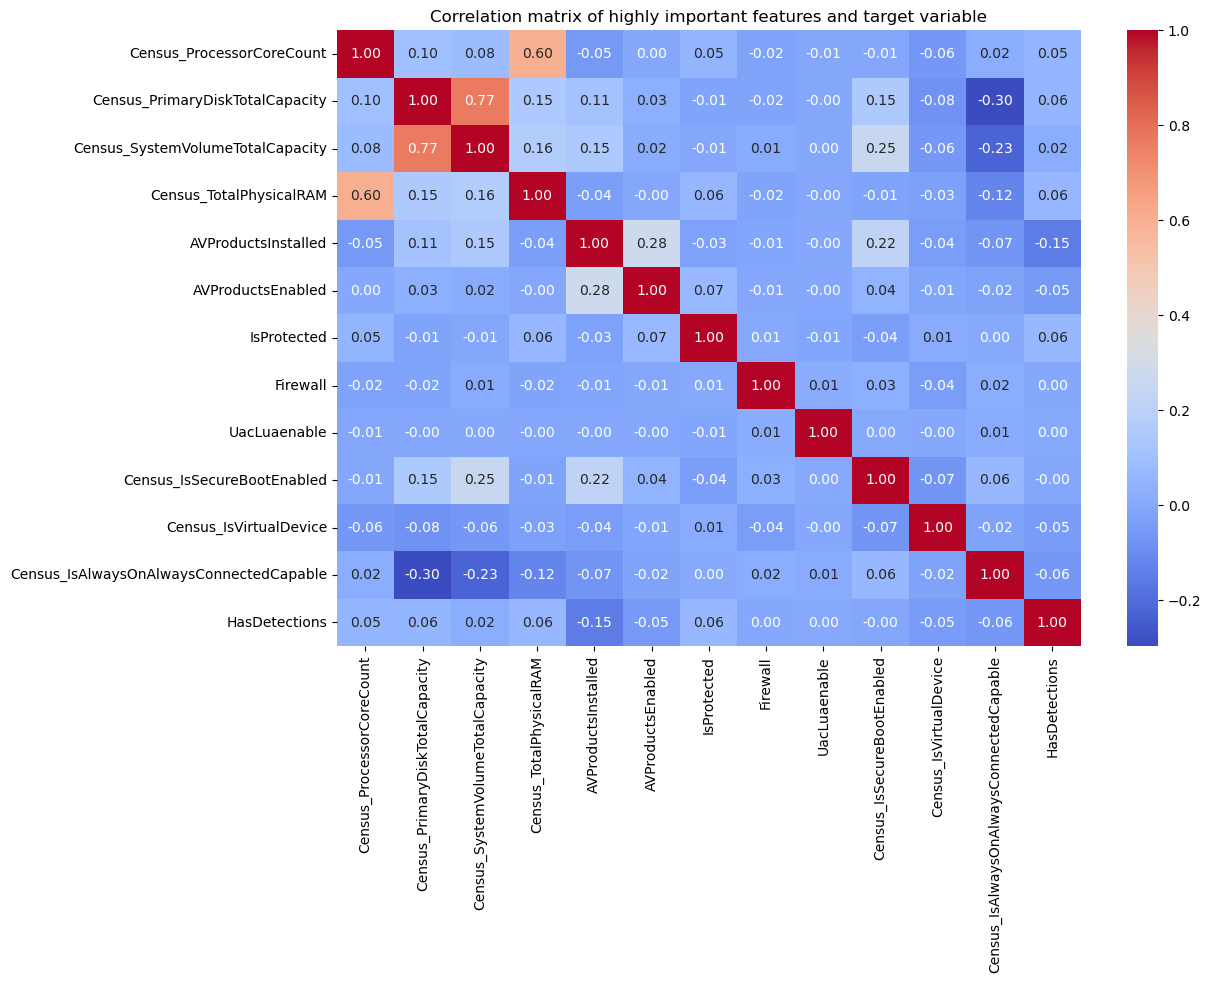

In [21]:
highly_important_features = ['Census_ProcessorCoreCount','Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM',
    "AVProductsInstalled", "AVProductsEnabled", "IsProtected",
    "Firewall", "UacLuaenable", "Census_IsSecureBootEnabled",
    "Census_IsVirtualDevice", "Census_IsAlwaysOnAlwaysConnectedCapable", "HasDetections"
]
correlation_df = malware_df[highly_important_features]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Draw the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Correlation matrix of highly important features and target variable")
plt.show()

Here, we combine the highly important features and the numerical features that are shown in the previous plots.
We can see that the outcome seems to have low correlationship with all these features, the highest absolute value of the correlation is 0.15.
The reason for low relationship might be:


*   The relationship between them are not linear
*   The features may have complex mutual effects on the outcome
*   There are more categorical features than numerical ones in the dataset


This leads us to have a careful choice of the machine learning models.





## 2. What models will be most suitable


As said above, the phenomenon of low correlation between each feature and the outcome is quite obvious. we need more sophisticated models that can capture complex relationships.
But at the same time, we still need some basic models to do the comparison.

Preferred Models (Classfication) : Decision Trees, Random Forest, Gradient Boosting Trees, Deep Learning Models.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
deci_tree = DecisionTreeClassifier()
rf_tree = RandomForestClassifier()
gbt_tree = HistGradientBoostingClassifier()
xgb_tree = xgb.XGBClassifier()

In [23]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
model = Sequential([ #Sample of using tensorflow to construct the neural network
    Dense(10, input_shape=(4,), activation='relu'),
    Dense(10, activation='relu'),
    Dense(3, activation='softmax')
])

Compare Models: Logistic Regression, KNN, SVM. (These models usually suspect easier relationships)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
logit_model = LogisticRegression()
knn_model = KNeighborsClassifier()
svm_model = SVC()

Their results will be compared under various metrics, including accuracy, precision, recall, f1-score. A comprehensive analysis will be conducted.

##3. Preprocessing suggestions

Standardization is necessary for the numerical data in model training and testing. Some of the models are quite sensitive to the scaling such as KNN and SVM models. No matter what, using standardization enables the model to run faster and more stable.

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_features = ['AVProductsInstalled', 'AVProductsEnabled', 'Census_ProcessorCoreCount',
                      'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM']
malware_df[numerical_features] = scaler.fit_transform(malware_df[numerical_features])
malware_df.head(5)

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,...,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,HasDetections,OSBuildCombined
0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.981.0,0,7.0,0,53447.0,-0.628449,-0.123193,...,IS_GENUINE,Retail,Retail,0,0.0,0,0,0.0,1,16299.371
2,win8defender,1.1.15200.1,4.18.1807.18075,1.275.644.0,0,7.0,0,53447.0,-0.628449,-0.123193,...,IS_GENUINE,OEM:NONSLP,Retail,0,0.0,0,0,0.0,0,17134.228
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1552.0,0,7.0,0,53447.0,-0.628449,-0.123193,...,INVALID_LICENSE,Retail,Retail,0,0.0,0,0,0.0,0,17134.112
4,win8defender,1.1.15200.1,4.18.1807.18075,1.275.948.0,0,7.0,0,53447.0,-0.628449,-0.123193,...,IS_GENUINE,Retail,Retail,0,0.0,0,0,0.0,0,17134.254
5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1504.0,0,7.0,0,53447.0,-0.628449,-0.123193,...,IS_GENUINE,OEM:DM,Retail,1,0.0,0,0,0.0,1,17134.191
